# Tree-Based Methods
- Tree-based classification models are a type of supervised machine learning algorithm that uses a series of conditional statements to partition training data into subsets
- There are numerous ensemble methds built upon decision trees


## Load Packages and Prep Data

In [1]:
# custom utils
from utils import custom
from utils.cf_matrix import make_confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import time

In [2]:
# load data
X_train, y_train, X_test, y_test = custom.load_data()

X_train (62889, 42)
y_train (62889,)
X_test (15723, 42)
y_test (15723,)


## Model 1 - Decision Tree

**Basic Description**

A decision tree is a model that can be represented in a treelike form determined by binary splits made in the feature space and resulting in various leaf nodes, each with a different prediction. Decision trees are flexible and often perform well in practice for both classification and regression use cases. Trees are trained in a greedy and recursive fashion, proceeding through a series of binary splits in features that lead to minimal error.

**Bias-Variance Tradeoff**

Highly flexible, leading to low bias but high variance

**Upsides**

**Downsides**

Risk of overfitting

**Other Notes**

### Hyperparameter Tuning
- Tune model with hyperparameter grid search
- Parameters:
    - The maximum depth of the tree `max_depth`
    - The minimum number of samples required to split an internal node `min_samples_split`
    - The minimum number of samples required to be at a leaf node `min_samples_leaf`. A split point at any depth will only be considered if it leaves at the minimum training samples in each resulting branch.
    - The number of features to consider when looking for the best split `max_features`

In [28]:
# define grid to search
param_grid={
        'max_depth': [9,10,11]
        ,'min_samples_split': [2,3]
        ,'min_samples_leaf': [1,2]
        ,'max_features': [0.5,0.6,0.7]
}

# instance
dt_gs = GridSearchCV(DecisionTreeClassifier()
                ,param_grid
                ,scoring='f1'
                ,cv=5
                ,n_jobs=-1
                #,verbose=1
    )

# search and fit
dt_gs.fit(X_train, y_train)

# best params and score
print(dt_gs.best_params_)
print(dt_gs.best_score_)

# store best model
dt = dt_gs.best_estimator_

{'max_depth': 9, 'max_features': 0.6, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.6923896633062643


In [29]:
# cross-validation scoring
dt_scores = custom.cv_metrics2(dt, X_train, y_train)
dt_scores

accuracy     0.962203
precision    0.771768
recall       0.619145
f1           0.686887
dtype: float64

## Model 2 - Random Forest

**Basic Description**

- A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

**Bias-Variance Tradeoff** 

- Like the underlying decision tree, Random Forest is highly flexible. Low bias, high variance. However, it has more methods for regularization.

**Upsides**

- Handles non-linear decision boundaries.
- Impervious to class imbalance. Can account for feature interactions

**Downsides**

- Large hyperparameter space

**Other Notes**

### Hyperparameter Tuning
- Tune model with hyperparameter grid search
- Search parameters
    - Number of trees `n_estimators`
    - Features considered at each split `max_features`
    - Maximum tree depth `max_depth`
    - Sub-sample size `max_samples`

In [41]:
# start timer
start = time.time()

# define grid to search
param_grid={
        'n_estimators': [75,100,125]
        ,'max_features': [0.9, None]
        #,'max_depth': [25,30,35]
        #,'min_samples_split': [2,3]
        #,'min_samples_leaf': [1,2]
        #,'bootstrap': [True,False]
        ,'max_samples': [0.7,0.8,0.9]
}

# instance
rf_gs = GridSearchCV(RandomForestClassifier()
                ,param_grid
                ,scoring='f1'
                ,cv=3
                ,n_jobs=-1
                #,verbose=1
    )

# search and fit
rf_gs.fit(X_train, y_train)

# best params and score
print(rf_gs.best_params_)
print(rf_gs.best_score_)

# store best model
rf = rf_gs.best_estimator_

# end timer
end = time.time()
print(round((end - start)/60,2),'min')

{'max_features': None, 'max_samples': 0.7, 'n_estimators': 125}
0.7358185262136437
17.85 min


In [42]:
# start timer
start = time.time()

# cross-validation scoring
rf_scores = custom.cv_metrics2(rf, X_train, y_train)
print(rf_scores)

# end timer
end = time.time()
print(round((end - start)/60,2),'min')

accuracy     0.968230
precision    0.840786
recall       0.649149
f1           0.732508
dtype: float64
7.98 min


## Model 3 - XGBoost

**Basic Description**
- XGBoost belongs to a class of models popular throughout many industries because of superior performance on a variety problems. Its benefits include capturing non-linear relationships, detecing complex interactions, and robustness to outliers and other data issues.
- An XGBoost model consists of many weak classifiers trained iteratively to reduce residuals, also known as boosting. This decision-tree based ensemble algorithm uses the gradient boosting framework, which allows for flexibility in loss function selection.

**Bias-Variance Tradeoff** 



**Upsides**



**Downsides**



**Other Notes**

### Initial Fit
- Good results with default hyperparameters

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
xgb_1 = xgb.XGBClassifier()
x = xgb_1.fit(X_train, y_train)

xgb_1_scores = custom.cv_metrics2(xgb_1, X_train, y_train)
xgb_1_scores

accuracy     0.969645
precision    0.848681
recall       0.665609
f1           0.745897
dtype: float64

### Random Hyperparameter Search
- Attempt to find improvement over defaults
- XGBoost has many hyperparameters combinations, so it is an efficient trade-off to do a random search and then refine with a grid search.
- Search parameters:
    - Number of trees `n_estimators`
    - Maximum tree depth `max_depth`
    - Learning rate `learning_rate`
    - Leaf weight regularization rates L1 `reg_alpha` and L2 `reg_lambda`
    - Complexity control `gamma`
    - Minimum child weight `min_child_weight`

 Reference: https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76

In [5]:
# start timer
start = time.time()

# define grid to search
param_grid={
        'n_estimators': [100,200,300]
        ,'max_depth': [2,4,6]
        ,'learning_rate': [0.2,0.3,0.4]
        ,'gamma': [0,10]
        ,'min_child_weight': [1,2,3]
        ,'reg_alpha': [0,0.1,0.2]
        ,'reg_lambda': [0.8,0.9,1]
}

# instance
xgb_gs = RandomizedSearchCV(xgb.XGBClassifier()
                ,param_grid
                ,scoring='f1'
                ,n_iter=100
                ,cv=3
                ,n_jobs=-1
                #,verbose=1
    )

# search and fit
xgb_gs.fit(X_train, y_train)

# best params and score
print(xgb_gs.best_params_)
print(xgb_gs.best_score_)

# store best model
xgb_2 = xgb_gs.best_estimator_

# end timer
end = time.time()
print(round((end - start)/60,2),'min')

{'reg_lambda': 0.8, 'reg_alpha': 0.2, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0}
0.7467227039368419
16.87 min


### Grid Hyperparameter Search

In [6]:
# start timer
start = time.time()

# define grid to search
param_grid={
        'n_estimators': [500,600]
        ,'max_depth': [3,4]
        ,'learning_rate': [0.2,0.3]
        ,'gamma': [0]
        ,'min_child_weight': [3,4]
        ,'reg_alpha': [0.2]
        ,'reg_lambda': [0.9]
}

# instance
xgb_gs = GridSearchCV(xgb.XGBClassifier()
                ,param_grid
                ,scoring='f1'
                ,cv=3
                ,n_jobs=-1
                #,verbose=1
    )

# search and fit
xgb_gs.fit(X_train, y_train)

# best params and score
print(xgb_gs.best_params_)
print(xgb_gs.best_score_)

# store best model
xgb_2 = xgb_gs.best_estimator_

# end timer
end = time.time()
print(round((end - start)/60,2),'min')

{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.9}
0.7462111470244094
6.89 min


In [7]:
xgb_2_scores = custom.cv_metrics2(xgb_2, X_train, y_train)
xgb_2_scores

accuracy     0.969550
precision    0.844207
recall       0.668553
f1           0.746127
dtype: float64

## Test

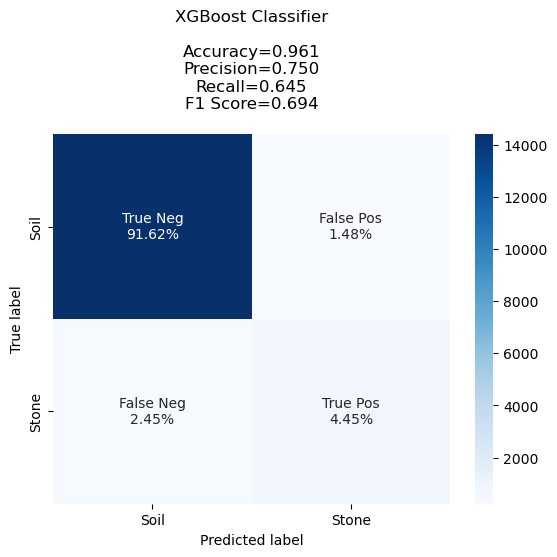

In [20]:
# test the performance of the selected model
y_pred = xgb_2.predict(X_test)
# pred_metrics(y_test, y_pred)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Soil', 'Stone']
make_confusion_matrix(cm
                      ,group_names=labels
                      ,categories=categories
                      ,cmap='Blues'
                      ,count=False
                      ,title = 'XGBoost Classifier')